In [ ]:
# Bot check

# HW_ID: ds_ml8
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

## Применение реализованных модулей (60 баллов)
Для начала определим путь до ноутбука с реализованными модулями.

In [3]:
import os

path_to_dir: str = os.getcwd()  # путь к папке с заданием
path_to_modules_notebook = path_to_dir + "\\1_modules.ipynb"  # путь к файлу с модулями

In [4]:
if 'google.colab' in str(get_ipython()):  # В Google Colab подключаемся к диску
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_modules_notebook = "drive/MyDrive/" + path_to_modules_notebook

Следующая ячейка делает `from 1_modules.ipynb import *`, таким образом позволяя этому ноутбуку видеть все модули.

In [5]:
%run $path_to_modules_notebook

test_LeakyReLU (__main__.TestLayers) ... ok
test_Linear (__main__.TestLayers) ... ok
test_LogSoftMax (__main__.TestLayers) ... ok
test_NLLCriterion (__main__.TestLayers) ... ok
test_ReLU (__main__.TestLayers) ... ok
test_Sequential (__main__.TestLayers) ... ok
test_SoftMax (__main__.TestLayers) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.731s

OK


После того, как все слои в `1_modules.ipynb` протестированы и работают корректно, проверим нейросеть на наборах синтетических данных.

In [6]:
import numpy as np
from sklearn import datasets
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
from torch.optim import SGD as torch_sgd

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF3300', '#00CC66'])
RANDOM_SEED = 42

sns.set(font_scale=1, palette='Set2')
np.random.seed(RANDOM_SEED)

Будем применять реализованные модули на синтетических данных.

### 1. Линейно разделимая выборка (35 баллов)

Обучим однослойную нейронную сеть решать линейно-разделимую классификацию на 2 класса.

In [7]:
n_samples, n_classes = 1024, 2
varied_blobs = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=n_classes, cluster_std=[1.0, 2.5], random_state=RANDOM_SEED)
sample, labels = varied_blobs

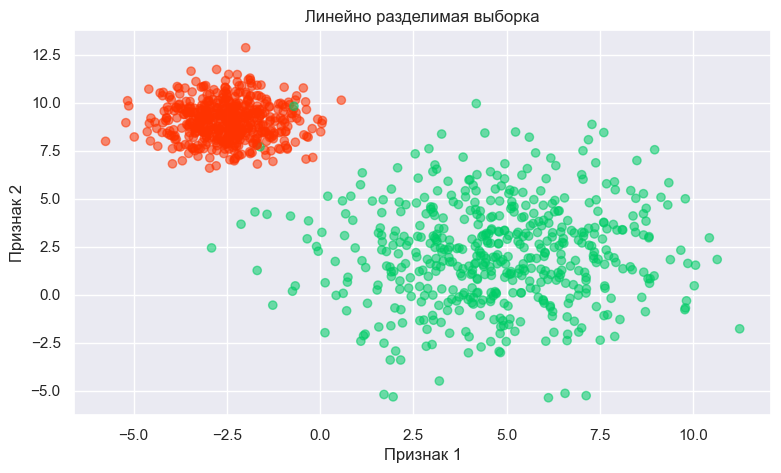

In [8]:
plt.figure(figsize=(9, 5))
plt.title('Линейно разделимая выборка')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.scatter(sample[:, 0], sample[:, 1], c=labels, cmap=cm_bright, alpha=0.55);

Генератор батчей. Помним, что нейросети обучаются итеративно $-$ по батчам.

In [9]:
def train_generator(sample, labels, batch_size):
    '''Генератор батчей. На каждом шаге возвращает `batch_size` объектов из `sample` и их меток из `labels`'''
    n_samples = sample.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)  # Перемешиваем в случайном порядке в начале эпохи
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx], labels[batch_idx]  # yield вместо return

Функция для удобного обучения модели.

In [10]:
def train_model(model, sample, y, criterion, opt_params, n_epoch, batch_size):
    '''
    Обучает модель из вашего мини-фреймворка. Возвращает обученную модель, историю значений функции потерь и метрики качества.
    :param `model`: модель из вашего мини-фреймворка
    :param `sample`: матрица объектов
    :param `y`: вектор истинных меток объектов
    :param `criterion`: функция потерь
    :param `opt_params`: гиперпараметры оптимизатора
    :param `n_epoch`: количество эпох
    :param `batch_size`: размер одного батча
    '''
    loss_history = []
    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            model.zero_grad_params()  # Обнуляем градиенты с предыдущей итерации
            predictions = model.forward(x_batch)  # Forward pass
            loss = criterion.forward(predictions, y_batch)
            model.backward(predictions, y_batch)  # Backward pass
            SGD(model.get_parameters(), model.get_grad_params(), opt_params)  # Обновление весов
            loss_history.append(loss)
        display.clear_output(wait=True)
        plt.figure(figsize=(6, 4))
        plt.title("Функция потерь на train")
        plt.xlabel("Итерация")
        plt.ylabel("Лосс")
        plt.ylim((-0.05,1.5))  # чтобы нагляднее было сравнивать 
        plt.plot(loss_history, 'b')
        plt.title(f'Loss: {loss:.3f}')
        plt.show()
    return model, loss_history

Построим однослойную нейросеть для классификации: размер слоя $2 \times 2$, так как 2 признака и 2 класса. В качестве последнего слоя рекомендуется использовать `LogSoftMax`.

In [11]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 2
LogSoftMax



Объявим оптимизируемую функцию потерь и гиперпараметры.

In [12]:
criterion = NLLCriterion()  # Функция потерь
optimizer_config = {'learning_rate' : 1e-2}  # Гиперпараметры оптимизатора
n_epoch, batch_size = 50, 128  # Гиперпараметры цикла обучения и генератора

Проверим, что кодирование производится верно.

In [13]:
y = np.hstack([1 - labels[:, None], labels[:, None]])
print(y.shape, labels[:10], y[:10], sep='\n')

(1024, 2)
[0 1 1 0 1 1 1 1 1 0]
[[1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]]


Обучим модель с помощью функции `train_model`.

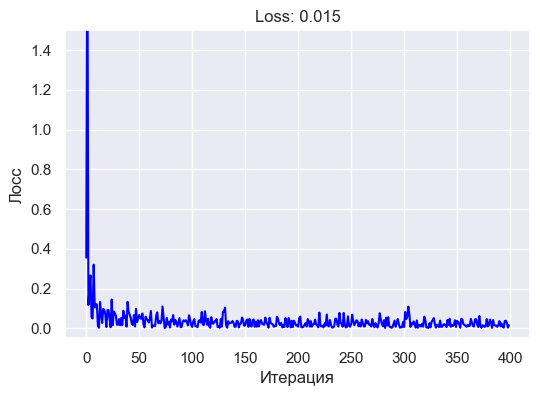

In [14]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())
net, loss_history = train_model(net, sample, y, criterion, optimizer_config, n_epoch, batch_size)

*Модель обучается, лосс довольно быстро падает. Это хороший знак*

Поменяйте гиперпараметр `learning_rate` в `optimizer_config` на `1e-1`, `1e-2`, `1e-3` и `1e-4`.

Как это влияет на обучение?

In [15]:
def set_lr_experiment(lr):
    '''Запускает тот же эксперимент с данным lr'''
    net = Sequential()
    net.add(Linear(2, 2))
    net.add(LogSoftMax())
    net, loss_history = train_model(net, sample, y, criterion, {'learning_rate':lr}, n_epoch, batch_size)

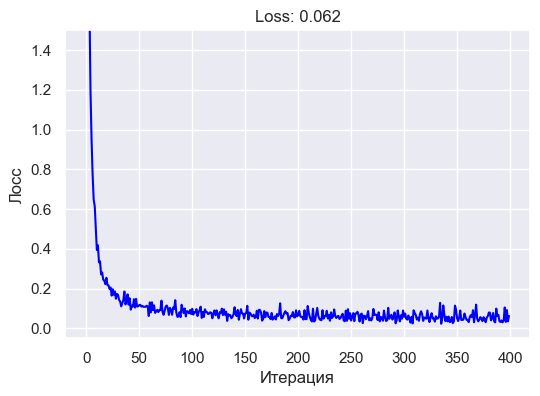

In [16]:
set_lr_experiment(1e-4)

*При lr=1e-4 лосс падает сравнительно плавно и флуктуирует слабо*

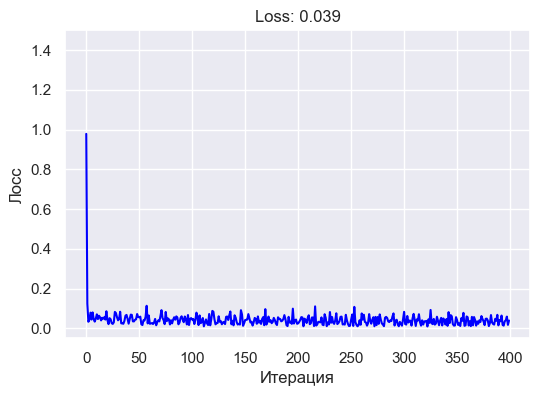

In [17]:
set_lr_experiment(1e-3)

*При lr=1e-3 лосс падает быстрее, а флуктуирует примерно так же слабо*

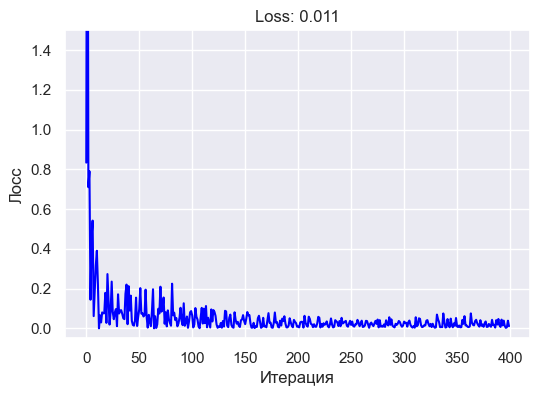

In [18]:
set_lr_experiment(1e-2)

*При lr=1e-2 лосс начинает флуктуировать сильнее. Финальное значение лосса получилось самым низким из всех четырех примеров, но пока это мало о чем говорит (как минимум, надо сравнить результаты на валидации)*

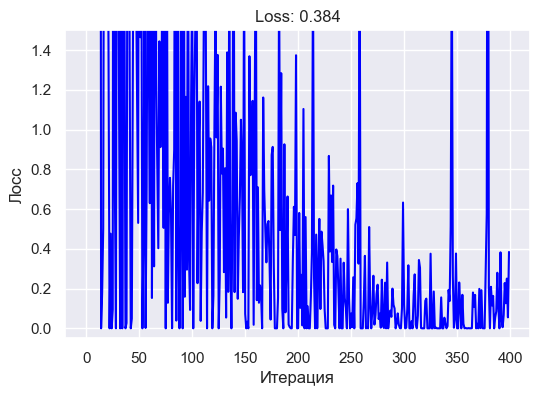

In [19]:
set_lr_experiment(1e-1)

*При lr=1e-1 лосс флуктуирует очень сильно. Говорить об обучении модели сложно, оптимизатор явно проскакивает оптимум*

***Вывод***  
*Learning rate - очень важный гиперпараметр. При слишком большом lr оптимизатор будет проскакивать оптимум и лосс будет сильно флуктуировать, а при слишком маленьком lr алгоритм не успеет дойти до оптимума или застрянет в какой-нибудь седловой точке. Удачное значение lr зависит от конкретной задачи, но, например, Карпати по опыту рекоммендует начинать подбор от характерного значения 3е-4*

Батч-генератор для тестовой выборки.

In [20]:
def generate_grid(sample, h=0.02):
    '''Генерирует двумерную сетку, возвращает 2 сетки - координаты x и координаты y'''
    x_min, x_max = sample[:, 0].min() - .5, sample[:, 0].max() + .5
    y_min, y_max = sample[:, 1].min() - .5, sample[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def test_generator(sample):
    '''Батч-генератор для тестовых данных (без меток)'''
    n_samples = sample.shape[0]
    indices = np.arange(n_samples)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx]

Функции для удобного тестирования модели.

In [21]:
def test_model(model, test_sample):
    '''Тестирует модель на тестовой выборке'''
    preds = []
    for test_batch in test_generator(test_sample):
        batch = model.forward(test_batch)
        batch = batch.argmax(axis=1).reshape(-1,1)
        preds.append(batch)
    preds = np.vstack(preds)
    return preds

def plot_grid_preds(sample, labels, xx, yy, preds, title):
    '''Функция для удобной отрисовки предсказаний нейросети на двумерной сетке'''
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.scatter(sample[:, 0], sample[:, 1], c=labels, cmap=cm_bright, alpha=0.55)
    plt.contourf(xx, yy, preds, alpha=.2, cmap=cm)
    plt.show();

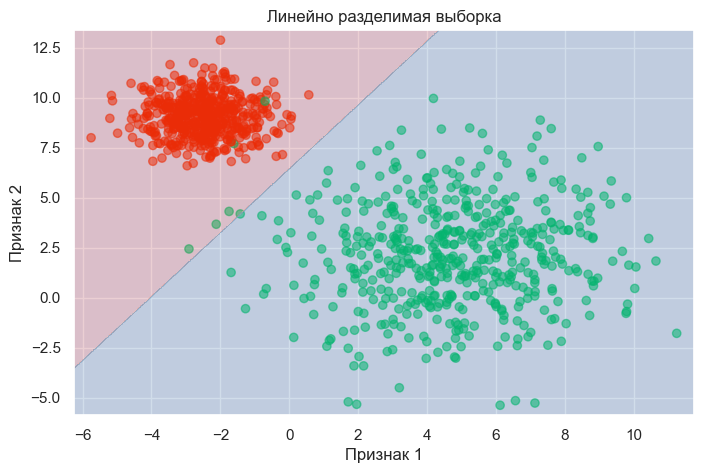

In [22]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())
net, loss_history = train_model(net, sample, y, criterion, {'learning_rate':1e-2}, n_epoch, batch_size)  # снова обучим модель с хорошим lr
display.clear_output(wait=True)

xx, yy = generate_grid(sample)  # получим набор точек с 2 координатами
test_sample = np.c_[xx.ravel(), yy.ravel()]
test_predictions = test_model(net, test_sample).reshape(xx.shape)
plot_grid_preds(sample, labels, xx, yy, test_predictions, 'Линейно разделимая выборка')

Сравним с точно такой же моделью, но на PyTorch.

*Подсказка.* Названия слоев идентичны, если брать их из `torch.nn`. Отличия только в оптимизаторе и названии функции потерь.

In [23]:
net_torch = nn.Sequential(nn.Linear(2,2), nn.LogSoftmax(dim=1))
print(net_torch)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): LogSoftmax(dim=1)
)


In [ ]:
def train_model_torch(model, sample, y, criterion, optimizer, n_epoch, batch_size):
    '''
    Обучает модель из PyTorch. Возвращает обученную модель, историю значений функции потерь и метрики качества.
    :param `model`: модель из PyTorch
    :param `sample`: матрица объектов
    :param `y`: вектор истинных меток объектов
    :param `criterion`: функция потерь
    :param `opt_params`: гиперпараметры оптимизатора
    :param `n_epoch`: количество эпох
    :param `batch_size`: размер одного батча
    '''
    loss_history = []
    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            x_batch, y_batch = torch.FloatTensor(x_batch), torch.LongTensor(y_batch[:, 1])
            optimizer.zero_grad()  # Обнуляем градиенты с предыдущей итерации
            outputs = model(x_batch)  # Forward pass
            loss = criterion(outputs, y_batch)
            loss.backward()  # Backward pass
            optimizer.step()  # Обновление весов
            loss_history.append(loss.data)
        display.clear_output(wait=True)
        plt.figure(figsize=(6, 5))
        plt.title("Функция потерь на train")
        plt.xlabel("итерация")
        plt.ylabel("лосс")
        plt.ylim((-0.05,1.5))  # чтобы нагляднее было сравнивать 
        plt.plot(loss_history, 'b')
        plt.show()
        print('Current loss: %f' % loss)
    return model, loss_history

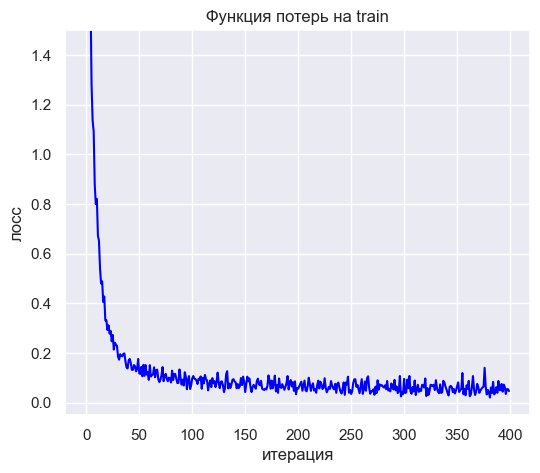

Current loss: 0.047393


In [25]:
criterion = nn.NLLLoss()
optimizer = torch_sgd(net_torch.parameters(), lr=0.01)
net_torch, loss_history = train_model_torch(net_torch, sample, y, criterion, optimizer, n_epoch, batch_size)

*Для самопроверки.* Значение функции потерь (лосса) должны быть примерно одинаковые у вашей модели и у сети из PyTorch. Каким именно на этом датасете $-$ см таблицу ниже.

|  Архитектура  | learning_rate | Значение лосса |
|-------------|---------------|-------------|
| Linear(2,2) |  1e-2         | 0.1 и ниже |

In [26]:
def test_torch(model, test_sample):
    '''Тестирует модель из PyTorch на тестовой выборке'''
    preds = []
    with torch.no_grad():
        for test_batch in test_generator(test_sample):
            preds_batch = model(torch.FloatTensor(test_batch)).argmax(axis=1).reshape(-1,1)
            preds.append(preds_batch.detach().numpy())
    preds = np.vstack(preds)
    return preds

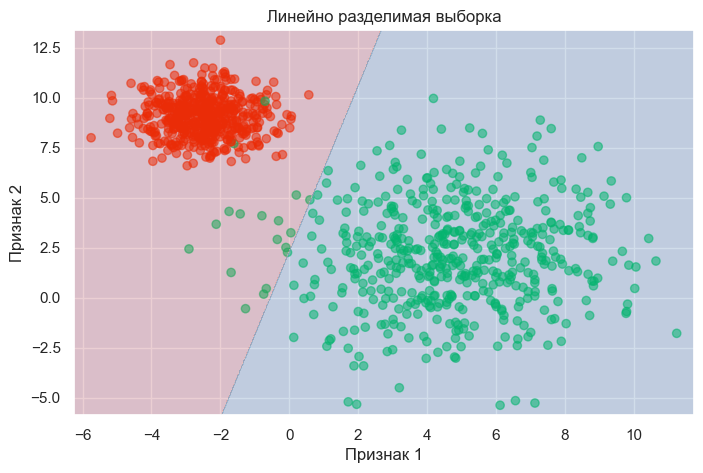

In [27]:
xx, yy = generate_grid(sample)  # получим набор точек с 2 координатами
test_sample = np.c_[xx.ravel(), yy.ravel()]
test_predictions = test_torch(net_torch, test_sample).reshape(xx.shape)
plot_grid_preds(sample, labels, xx, yy, test_predictions, 'Линейно разделимая выборка')

Рисунки с предсказаниями должны практически совпадать у вашей модели и у модели на PyTorch.

*Графики действительно получились довольно похожими*

*Интересно, что даже столь простая архитектура смогла справиться с линейно разделимым случаем*

### 2. Вложенные окружности (30 баллов)

Проверим работу нейросети на более сложной выборке, которая линейно не разделима в исходном пространстве признаков.

In [28]:
noisy_circles = datasets.make_circles(n_samples=1024, factor=.5, noise=.05)
sample, labels = noisy_circles

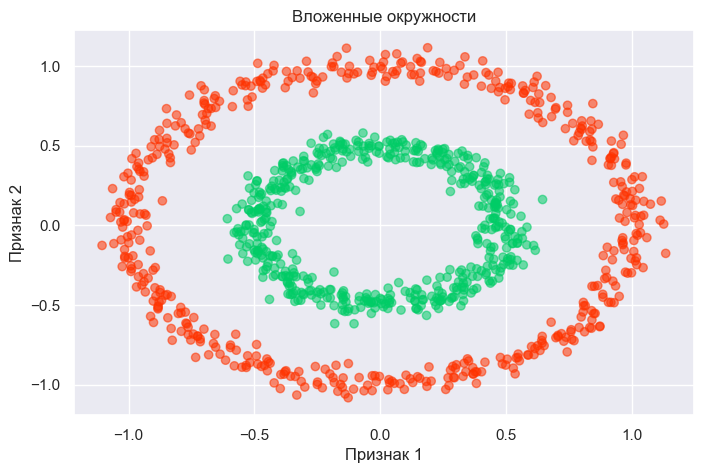

In [29]:
plt.figure(figsize=(8, 5))
plt.title('Вложенные окружности')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.scatter(sample[:,0], sample[:,1], c=labels, cmap=cm_bright, alpha=0.55);

Сначала попробуем обучить и протестировать однослойную нейросеть:

In [30]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())
print(net)

criterion = NLLCriterion()  # Функция потерь
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}  # Гиперпараметры оптимизатора
n_epoch, batch_size = 50, 128  # Гиперпараметры цикла обучения и генератора

Linear 2 -> 2
LogSoftMax



In [31]:
y = np.hstack([1 - labels[:, None], labels[:, None]])
print(y.shape)
print(labels[:10])
print(y[:10])

(1024, 2)
[0 1 0 1 0 0 1 1 0 1]
[[1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]


Обучим и визуализируем предсказания:

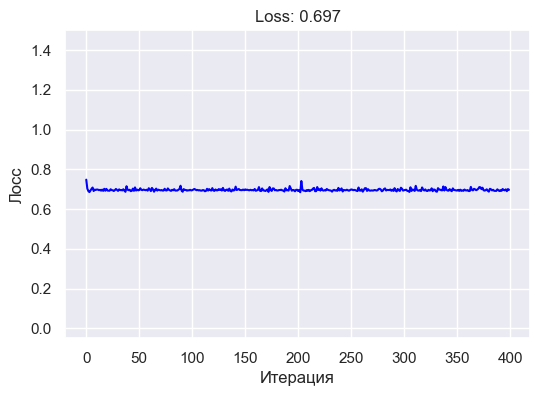

In [32]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())
net, loss_history = train_model(net, sample, y, criterion, optimizer_config, n_epoch, batch_size)

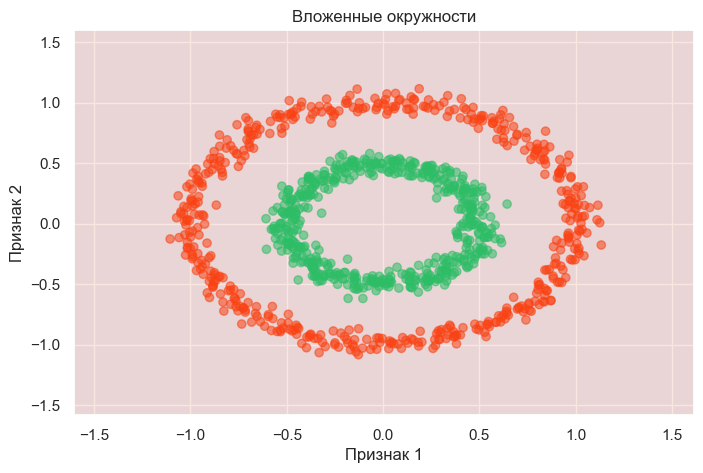

In [33]:
xx, yy = generate_grid(sample)  # получим набор точек с 2 координатами
test_sample = np.c_[xx.ravel(), yy.ravel()]
test_predictions = test_model(net, test_sample).reshape(xx.shape)
plot_grid_preds(sample, labels, xx, yy, test_predictions, 'Вложенные окружности')

*Не научились разделять. Явное недообучение -> нужно усложнять архитектуру*

Вряд ли у вас получился лосс ниже 0.68 и адекватный рисунок. Это говорит о том, что один слой не может решить задачу.

Попробуем сделать **двухслойную** нейросеть. Не жалейте нейронов в скрытый слой. Окружности должны хорошо отделяться начиная с 30-40 нейронов.

*Подсказка.* Не забудьте про нелинейности.

In [34]:
net = Sequential()
net.add(Linear(2, 100))
net.add(ReLU())
net.add(Linear(100, 2))
net.add(LogSoftMax())
print(net)

criterion = NLLCriterion()
optimizer_config = {'learning_rate' : 1e-2}
n_epoch, batch_size = 100, 128
y = np.hstack([1 - labels[:, None], labels[:, None]])
print(y.shape)

Linear 2 -> 100
ReLU
Linear 100 -> 2
LogSoftMax

(1024, 2)


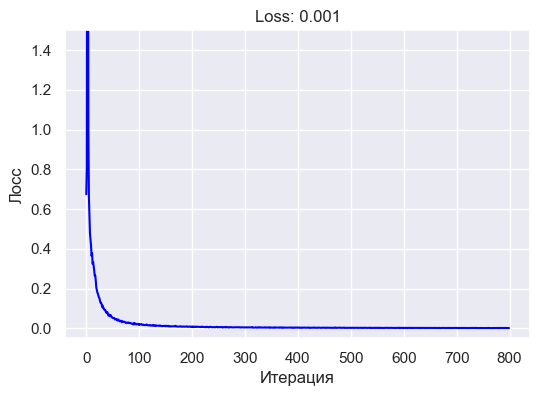

In [35]:
net, loss_history = train_model(net, sample, y, criterion, optimizer_config, n_epoch, batch_size)

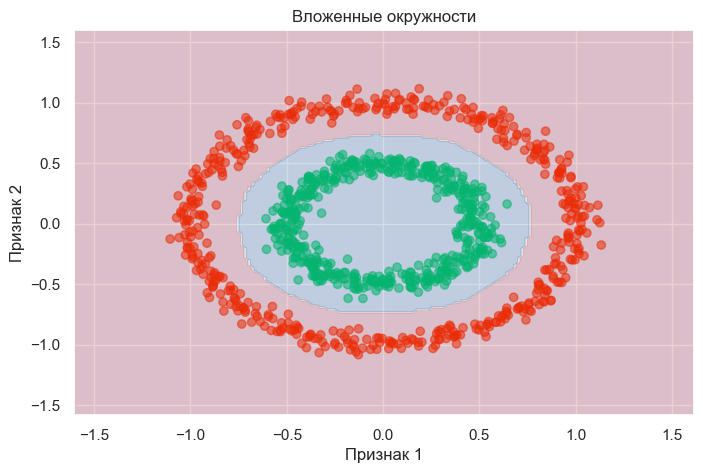

In [36]:
xx, yy = generate_grid(sample) 
test_sample = np.c_[xx.ravel(), yy.ravel()]
test_predictions = test_model(net, test_sample).reshape(xx.shape)
plot_grid_preds(sample, labels, xx, yy, test_predictions, 'Вложенные окружности')

*Стало заметно лучше*

И снова сравним с PyTorch.

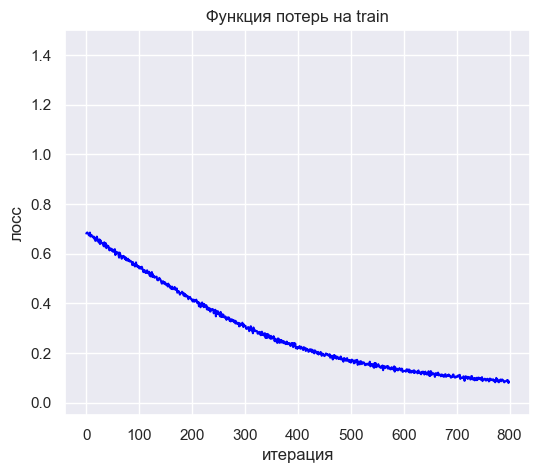

Current loss: 0.085887


In [37]:
net_torch = net_torch = nn.Sequential(nn.Linear(2,100), nn.ReLU(), nn.Linear(100,2), nn.LogSoftmax(dim=1))
print(net_torch)

criterion = nn.NLLLoss()
optimizer = torch_sgd(net_torch.parameters(), lr=0.05)
net_torch, loss_history = train_model_torch(net_torch, sample, y, criterion, optimizer, n_epoch, batch_size)

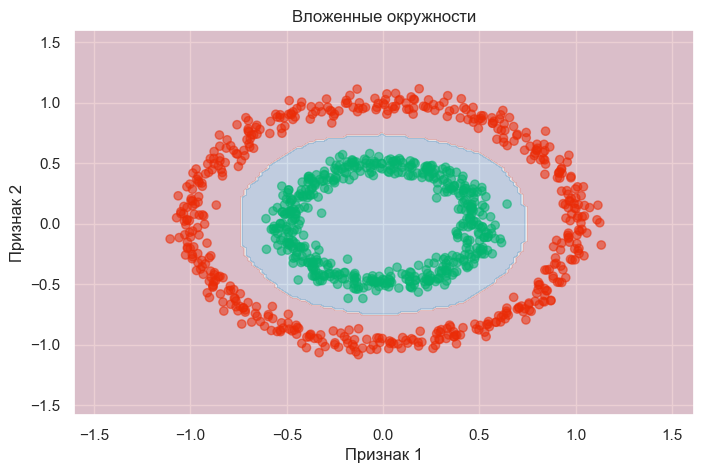

In [38]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]
test_predictions = test_torch(net_torch, test_sample).reshape(xx.shape)
plot_grid_preds(sample, labels, xx, yy, test_predictions, 'Вложенные окружности')

*Похоже на правду, совпало с таблицей*

*Для самопроверки*. Значение функции потерь (лосса) должны быть примерно одинаковые у вашей модели и у сети из PyTorch. Каким именно на этом датасете $-$ см. таблицу ниже.

|  Архитектура  | learning_rate | Значение лосса |
|-------------|---------------|-------------|
| (2,100) -> ReLU -> (100,2) |  1e-2         | 0.5 и ниже |

Оба рисунка должны примерно совпадать и адекватно разделять окружности между собой (одна область должна быть "внутри" другой).

### 3. Заключение (5 баллов)

Сделайте выводы по проведенным экспериментам.

***Выводы:** в задаче удалось ближе познакомиться с нейросетями и на практике проверить работоспособность написанных классов. Основные выводы по этому ноутбуку:*  
*1) Learning rate - очень важный гиперпараметр. При слишком большом lr оптимизатор будет проскакивать оптимум и лосс будет сильно флуктуировать, а при слишком маленьком lr алгоритм не успеет дойти до оптимума или застрянет в какой-нибудь седловой точке. Удачное значение lr зависит от конкретной задачи, но, например, Карпати по опыту рекоммендует начинать подбор от характерного значения 3е-4*  
*2) Задачи могут сильно отличаться по своей сложности для алгоритма, даже если кажутся простыми человеку. Наглядный пример - линейно разделимые множества и вложенные окружности. Оба примера кажутся простыми на первый взгляд, но для работы со вторым понадобилось заметно усложнить модель. Итог: задачи в ML могут требовать индивидуального подхода и тщательного подбора архитектуры модели*  
*3) Модульное ("слоёное") строение нейросетей позволяет сузить класс возможных моделей и упростить подбор оптимальной архитектуры - по крайней мере на простых задачах. В то же время, удивляет насколько эффективно нейросети могут справляться с задачами*  

### Полезные ссылки

- [Заметки главы ИИ в Tesla Andrej Karpathy по обучению нейросетей](http://karpathy.github.io/2019/04/25/recipe/)
- [Backpropagation на brilliant.org](https://brilliant.org/wiki/backpropagation/)
- См. ссылки в `1_modules.ipynb`